In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sys
import os
import json
import itertools
import umap
from colour import Color
from collections import Counter
sys.path.insert(1, "C:/Users/Eddie/Documents/language_change_methods")
sys.path.insert(1, "C:/Users/Eddie/Documents/language-change-application/flat-earth-forum/analysis")

from group_analysis import do_kmeans_clustering, plot_clusters, log_and_scale, colour_list, display_group_kw_combis
from helpers import load_posts, load_toks, load_pos, get_top_n_toks
from features import get_tok_counts, function_words, combine_counts, make_feature_matrix
from clustering import reduce_features, make_elbow_plot, compare_binary_normed_feature_embeddings, mc_list, plot_bin_and_norm_clusters, plot_contingency_matrix, calculate_cluster_lrs
from utility_functions import basic_preprocessing, get_ngram_example, get_text_example_of_pos

from sklearn.cluster import KMeans, SpectralClustering, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

from nltk import ngrams as make_ngrams

DB_FP = "C:/Users/Eddie/Documents/Datasets/Flat Earth/little_fe_forum.db"
GRAPH_DIR = "C:/Users/Eddie/Documents/Datasets/Flat Earth Graphs/Clustering"

In [2]:
%%time
all_posts = load_posts(DB_FP)

flat_earth_boards = [5, 7, 8, 19, 23]
other_boards = [9, 10, 11, 12]

fe_posts = all_posts.query("board_id in @flat_earth_boards")
ot_posts = all_posts.query("board_id in @other_boards")

toks = {int(x[0]): x[1] for x in load_toks("C:/Users/Eddie/Documents/Datasets/Flat Earth/TFES_CHUNKS_TOKENISED/tfes_posts.json")}
toks = pd.Series(toks)
toks = toks[toks.index.isin(fe_posts.index)]

pos = {int(x[0]): x[1] for x in load_pos("C:/Users/Eddie/Documents/Datasets/Flat Earth/TFES_CHUNKS_TOKENISED/tfes_posts.json")}
pos = pd.Series(pos)
pos = pos[pos.index.isin(fe_posts.index)]
pos = pos.loc[toks.index]

fe_posts = fe_posts.loc[toks.index]

Wall time: 35.1 s


In [3]:
with open("C:/Users/Eddie/Documents/Datasets/Flat Earth/user_metagroup.json") as group_file:
    meta_clusts = pd.Series(json.load(group_file))
    meta_clusts.index = meta_clusts.index.astype("float64")

In [4]:
# USERS_TO_INCLUDE = "100POSTS"
USERS_TO_INCLUDE = "TOP20"

In [5]:
post_lengths = toks.apply(len)
user_n_words = post_lengths.groupby(fe_posts["poster_id"]).sum()
posts_per_user = fe_posts.groupby("poster_id").size()

over_100 = posts_per_user[posts_per_user > 100]
print(f"{len(over_100)} with > 100 posts")

top_20 = posts_per_user.sort_values(ascending=False).head(20)
print(f"{len(over_100)} in the top 20")

if USERS_TO_INCLUDE == "100POSTS":
    curr_users = over_100
elif USERS_TO_INCLUDE == "TOP20":
    curr_users = top_20
    
user_n_words = user_n_words.loc[curr_users.index]
posts_per_user = posts_per_user.loc[curr_users.index]

curr_posts = fe_posts.query("poster_id in @curr_users.index")

# Get colour gradient
colour_gradient = list(Color("red").range_to(Color("blue"),len(curr_users)))
colour_gradient = pd.Series(colour_gradient, index=curr_users.sort_values(ascending=True).index)
colour_gradient = colour_gradient.loc[curr_users.index].apply(str)

101 with > 100 posts
101 in the top 20


# Create the user text chunks

In [6]:
merge_lists = lambda x: list(itertools.chain.from_iterable(x))

def get_chunks(u, tokens, chunk_size):
    for i in range(0, len(tokens)-chunk_size, chunk_size):
        yield u, tokens[i:i+chunk_size]

In [7]:
def make_tok_chonks(tokens, chunk_size):
    user_chunks = [[[user, chunk] for user, chunk in get_chunks(user, curr_toks, chunk_size)] for user, curr_toks in tokens.items()]
    user_chunks = merge_lists(user_chunks)
    user_chunks = pd.DataFrame(user_chunks, columns=["User", "Chunk"])
    return user_chunks

In [8]:
CHUNK_SIZE = 1000

In [9]:
%%time
user_toks = toks.groupby(curr_posts["poster_id"]).apply(merge_lists)
user_chunks = make_tok_chonks(user_toks, CHUNK_SIZE)

Wall time: 573 ms


In [10]:
%%time
user_pos = pos.groupby(curr_posts["poster_id"]).apply(merge_lists)
user_pos_chunks = make_tok_chonks(user_pos, CHUNK_SIZE)

Wall time: 664 ms


# Create the Different Feature Counts

#### BOW

In [11]:
%%time
# Get the counts
bow_counts = {i: get_tok_counts(post) for i, post in user_chunks["Chunk"].items()}
bow_counts = {i: {tok: count for tok, count in post.items() if tok not in function_words} for i, post in bow_counts.items()}
top_n = get_top_n_toks(bow_counts.values(), 5000)
bow_counts = {i: {tok: count for tok, count in post.items() if tok in top_n} for i, post in bow_counts.items()}
bow_counts = pd.Series(bow_counts)

Wall time: 21.4 s


#### Tfidf bow counts

In [12]:
%%time
# Credit for this cell: http://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/
from sklearn.feature_extraction.text import TfidfVectorizer
# If you had counts instead of tokens, you'd use "TfidfTransformer"

def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  


tfidf_matrix = tfidf.fit_transform(user_chunks["Chunk"])

Wall time: 866 ms


In [13]:
tfidf_feats = tfidf_matrix[:, np.isin(tfidf.get_feature_names(), top_n)].todense()

#### PoS Trigrams

In [14]:
pos_trigrams = pd.Series([make_ngrams(post, 3) for post in user_pos_chunks["Chunk"]], index=user_pos_chunks.index)
pos_trigrams = pos_trigrams.apply(lambda post: ["_".join(words) for words in post])

In [15]:
top_n = [x[0] for x in Counter(merge_lists(pos_trigrams)).most_common(1000)]
pos_tri_counts = pos_trigrams.apply(Counter).apply(lambda dic: {w: c for w, c in dic.items() if w in top_n})
pos_tri_counts = pd.Series(pos_tri_counts)

In [16]:
pos_tri_chunks = pd.DataFrame(index=user_pos_chunks.index)
pos_tri_chunks["User"] = user_pos_chunks["User"]
pos_tri_chunks["Chunk"] = pos_trigrams

In [17]:
# %%time
# pos_trigrams = pd.Series([make_ngrams(post, 3) for post in pos], index=pos.index)
# pos_trigrams = pos_trigrams.apply(lambda post: ["_".join(words) for words in post])
# u_pos_tri =  pos_trigrams.groupby(fe_posts["poster_id"]).apply(merge_lists)

# pos_tri_chunks = make_tok_chonks(u_pos_tri.loc[curr_users.index], CHUNK_SIZE)

In [18]:
# %%time
# top_n = [x[0] for x in Counter(merge_lists(pos_trigrams.loc[curr_posts.index])).most_common(1000)]
# pos_tri_counts = pos_tri_chunks["Chunk"].apply(Counter).apply(lambda dic: {w: c for w, c in dic.items() if w in top_n})
# pos_tri_counts = pd.Series(pos_tri_counts)

# Create the Feature Matrix

In [19]:
%%time
# Initialise feats to None
bin_feats = None
norm_feats = None

# Make the feature matrix
curr_feat_type = "pos_tri"
SCALE = True
APPLY_PCA = True

if curr_feat_type == "pos_tri":
    curr_counts = pos_tri_counts
    curr_chunks = pos_tri_chunks
elif curr_feat_type == "bow":
    curr_counts = bow_counts
    curr_chunks = user_chunks
elif curr_feat_type == "tfidf":
    curr_counts = bow_counts
    curr_chunks = user_chunks
    bin_feats = np.vectorize(lambda x: 1 if x > 0 else 0)(tfidf_feats)
    norm_feats = tfidf_feats
    
if bin_feats is None:
    curr_feats, curr_feat_names = make_feature_matrix(curr_counts.to_dict(), False)
    bin_feats = np.vectorize(lambda x: 1 if x > 0 else 0)(curr_feats)
    norm_feats = curr_feats / curr_chunks["Chunk"].apply(len).values[:,None]

Wall time: 1.01 s


#### Scaling

In [20]:
if SCALE:
    norm_feats = StandardScaler().fit_transform(norm_feats)

#### PCA reduction

In [21]:
%%time
from sklearn.decomposition import PCA
pca = PCA(.95)

if APPLY_PCA:
    norm_feats = pca.fit_transform(norm_feats)

Wall time: 902 ms


#### Make 2d embeddings

In [22]:
%%time
bin_embedding = reduce_features(bin_feats)
norm_embedding = reduce_features(norm_feats)

Wall time: 31.2 s


# Do the Clustering

In [23]:
%%time
# scaled = StandardScaler().fit_transform(bin_feats)
clst = KMeans(n_clusters=2, random_state=123)
bin_clusters = clst.fit_predict(bin_feats)

# scaled = StandardScaler().fit_transform(norm_feats)
clst = KMeans(n_clusters=2, random_state=123)
norm_clusters = clst.fit_predict(norm_feats)

Wall time: 598 ms


In [24]:
avg_silhouette_score = metrics.silhouette_score(bin_feats, bin_clusters)
print("Average silhoette score for Binary:\t", avg_silhouette_score, "\n")

avg_silhouette_score = metrics.silhouette_score(norm_feats, norm_clusters)
print("Average silhoette score for Normed:\t", avg_silhouette_score, "\n")

Average silhoette score for Binary:	 0.013200325757651428 

Average silhoette score for Normed:	 0.015375599857928014 



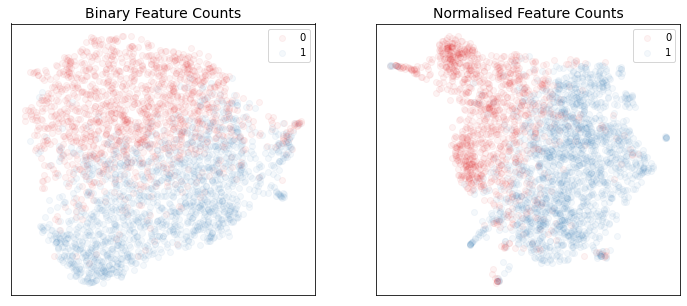

In [25]:
plot_bin_and_norm_clusters(bin_embedding, norm_embedding, 
                           bin_clusters, norm_clusters, 
                           alpha=0.05, out_fp=os.path.join(GRAPH_DIR, f"chunks_clusters_{curr_feat_type}.pdf"))

In [26]:
def chunk_cluster_info(f_name, X, chunk_users, clusters):
    print("------------------------------------------------------------------------------")
    print(f_name)
    print("------------------------------------------------------------------------------")

    sample_silhouette_values = metrics.silhouette_samples(X, clusters)
    
    for clust in set(clusters):
        num_chunks = len(clusters[clusters==clust])
        clust_users = chunk_users[clusters==clust]
    
        print("{0:10}\t{1:10}\t{2:10}\t{3:10.4f}".format(clust, 
                                              num_chunks, 
                                              len(clust_users.unique()), 
                                              sample_silhouette_values[clusters == clust].mean()))

In [27]:
for f_name, X, clusters in zip(["Binary", "Normalised"], [bin_feats, norm_feats], [bin_clusters, norm_clusters]):
    chunk_cluster_info(f_name, X, curr_chunks["User"], clusters)


------------------------------------------------------------------------------
Binary
------------------------------------------------------------------------------
         0	      1394	        19	    0.0017
         1	      1529	        20	    0.0237
------------------------------------------------------------------------------
Normalised
------------------------------------------------------------------------------
         0	      1177	        20	    0.0379
         1	      1746	        20	    0.0002


## Run with 20 clusters too

In [28]:
%%time
# scaled = StandardScaler().fit_transform(bin_feats)
clst = KMeans(n_clusters=20, random_state=123)
bin_clusters_20 = clst.fit_predict(bin_feats)

# scaled = StandardScaler().fit_transform(norm_feats)
clst = KMeans(n_clusters=20, random_state=123)
norm_clusters_20 = clst.fit_predict(norm_feats)

Wall time: 2.92 s


In [29]:
avg_silhouette_score = metrics.silhouette_score(bin_feats, bin_clusters_20)
print("Average silhoette score for Binary:\t", avg_silhouette_score, "\n")

avg_silhouette_score = metrics.silhouette_score(norm_feats, norm_clusters_20)
print("Average silhoette score for Normed:\t", avg_silhouette_score, "\n")

Average silhoette score for Binary:	 0.0004678074409094327 

Average silhoette score for Normed:	 -0.0009618391057673093 



In [30]:
for f_name, X, clusters in zip(["Binary", "Normalised"], [bin_feats, norm_feats], [bin_clusters_20, norm_clusters_20]):
    chunk_cluster_info(f_name, X, curr_chunks["User"], clusters)

------------------------------------------------------------------------------
Binary
------------------------------------------------------------------------------
         0	        63	         7	    0.0323
         1	       151	        11	    0.0013
         2	       249	        15	    0.0000
         3	        62	         7	   -0.0019
         4	       113	         6	    0.0230
         5	       209	        10	   -0.0051
         6	        93	         8	    0.0006
         7	        13	         6	   -0.0050
         8	       176	        12	   -0.0072
         9	       174	         9	   -0.0025
        10	       137	         8	    0.0050
        11	       185	        13	   -0.0028
        12	       112	        10	   -0.0030
        13	       239	        10	    0.0003
        14	       174	        10	    0.0034
        15	       169	        16	   -0.0083
        16	       165	        17	    0.0072
        17	       127	         9	   -0.0007
        18	       131	        11	   -0.0072

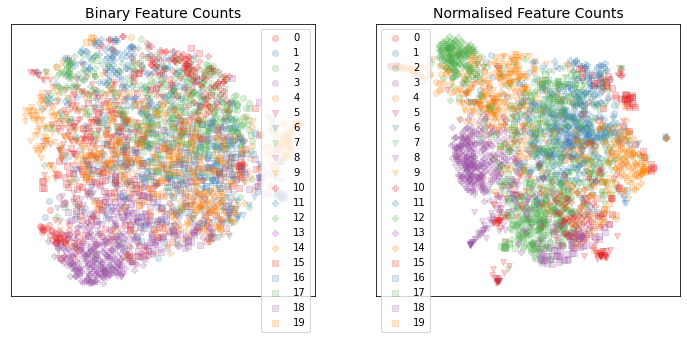

In [31]:
plot_bin_and_norm_clusters(bin_embedding, norm_embedding, bin_clusters_20, norm_clusters_20, alpha=0.2)

# Find Suitable Number of Clusters

In [32]:
%%time
# make_elbow_plot(bin_feats, start=1, end=100, step=20, scaler=None)

Wall time: 0 ns


In [33]:
%%time
# make_elbow_plot(scaled, start=1, end=100, step=20, scaler=None)

Wall time: 0 ns


# Analyse Spread Across Users

In [34]:
bin_contingency = pd.crosstab(curr_chunks["User"].values, [bin_clusters], rownames=["User"], colnames=["Cluster"])

In [35]:
print(f"{'Cluster':10}\t{'Num Users':10}\t{'Num Chunks':10}\t{'Chunks/Users':10}")
for clust in range(len(set(bin_clusters))):
    n_users = len(curr_chunks["User"][bin_clusters==clust].unique())
    clust_size = len(bin_clusters[bin_clusters==clust])
    print(f"{clust:10}\t{n_users:10}\t{clust_size:10}\t{clust_size/n_users:10.2f}")

Cluster   	Num Users 	Num Chunks	Chunks/Users
         0	        19	      1394	     73.37
         1	        20	      1529	     76.45


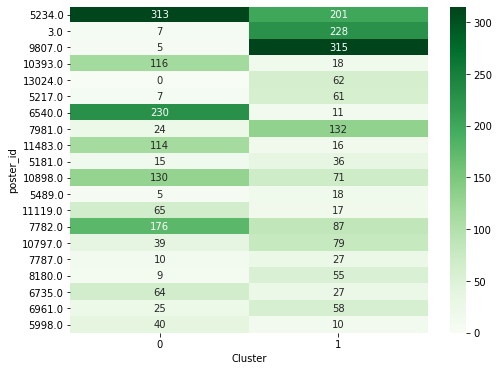

In [36]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bin_contingency.loc[posts_per_user.sort_values(ascending=False).head(20).index], annot=True, ax=ax, fmt='g', cmap="Greens")
fig.savefig(os.path.join(GRAPH_DIR, f"chunk_contingency_2_{curr_feat_type}.pdf"))
plt.show()

In [37]:
norm_contingency = pd.crosstab(curr_chunks["User"].values, [norm_clusters], rownames=["User"], colnames=["Cluster"])

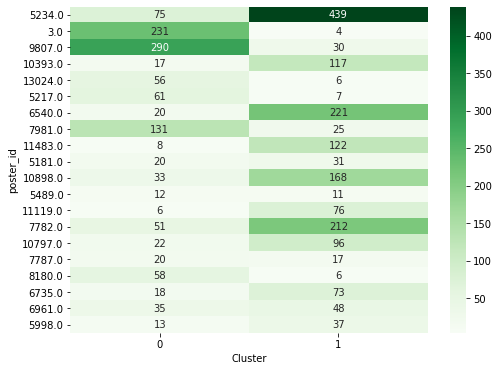

In [38]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(norm_contingency.loc[posts_per_user.sort_values(ascending=False).head(20).index], annot=True, ax=ax, fmt='g', cmap="Greens")
plt.show()

In [39]:
# The predicted cluster for each user.
norm_contingency.idxmax(axis=1)

User
3.0        0
5181.0     1
5217.0     0
5234.0     1
5489.0     0
5998.0     1
6540.0     1
6735.0     1
6961.0     1
7782.0     1
7787.0     0
7981.0     0
8180.0     0
9807.0     0
10393.0    1
10797.0    1
10898.0    1
11119.0    1
11483.0    1
13024.0    0
dtype: int64

In [40]:
# The percentage of a user's chunks that go in their larger cluster
# See it as the probability of being in the correct cluster
correct_cluster_prob = norm_contingency.apply(lambda x: x[x.idxmax()], axis=1) / norm_contingency.sum(axis=1)
correct_cluster_prob.sort_values(ascending=False)

User
3.0        0.982979
11483.0    0.938462
11119.0    0.926829
6540.0     0.917012
9807.0     0.906250
8180.0     0.906250
13024.0    0.903226
5217.0     0.897059
10393.0    0.873134
5234.0     0.854086
7981.0     0.839744
10898.0    0.835821
10797.0    0.813559
7782.0     0.806084
6735.0     0.802198
5998.0     0.740000
5181.0     0.607843
6961.0     0.578313
7787.0     0.540541
5489.0     0.521739
dtype: float64

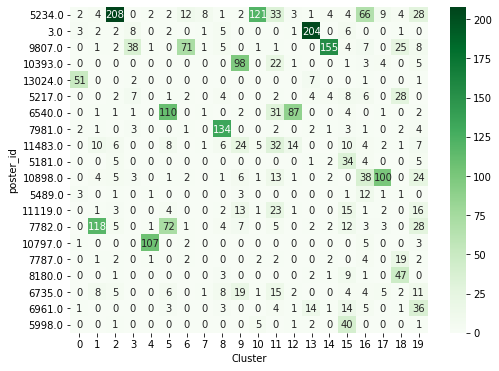

In [41]:
# For 20 clusters
bin_contingency_20 = pd.crosstab(curr_chunks["User"].values, [bin_clusters_20], rownames=["User"], colnames=["Cluster"])

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bin_contingency_20.loc[posts_per_user.sort_values(ascending=False).head(20).index], annot=True, ax=ax, fmt='g', cmap="Greens")

fig.savefig(os.path.join(GRAPH_DIR, f"chunk_contingency_20_{curr_feat_type}.pdf"))

plt.show()

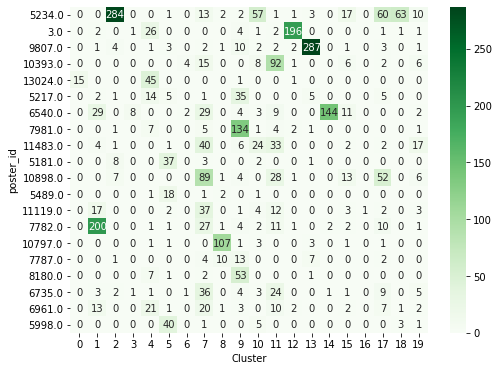

In [42]:
# For 20 clusters
norm_contingency_20 = pd.crosstab(curr_chunks["User"].values, [norm_clusters_20], rownames=["User"], colnames=["Cluster"])

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(norm_contingency_20.loc[posts_per_user.sort_values(ascending=False).head(20).index], annot=True, ax=ax, fmt='g', cmap="Greens")
plt.show()

# Get Some Keywords Between Clusters

In [43]:
%%time
lr = lambda x, y: np.log2(x / y)
# curr_counts = bow_counts
clusters = bin_clusters

clust_counts = curr_counts.groupby(clusters).apply(combine_counts).apply(lambda x: x[0])
clust_n_words = {clust: len(clusters[clusters==clust]) * CHUNK_SIZE for clust in range(len(set(clusters)))}

Wall time: 940 ms


In [44]:
%%time
for clust, counts in clust_counts.items():
    other_counts = combine_counts(curr_counts[clusters!=clust])[0]
    other_nwords = len(clusters[clusters!=clust]) * CHUNK_SIZE
    lrs = calculate_cluster_lrs(counts, other_counts, clust_n_words[clust], other_nwords)
    lrs = {w: l for w, l in lrs.items() if counts[w] > 100}
    lrs = pd.Series(lrs).sort_values(ascending=False)
    t10_lr = lrs.head(20)
    b10_lr = lrs.tail(20)
    
    print(clust)
    print("-------------------------------------------------------------------------------------")
    for (w1, lr1), (w2, lr2) in zip(t10_lr.items(), b10_lr.items()):
        print(f"{w1:20}\t{lr1:10.2f}\t|\t{w2:20}\t{lr2:10.2f}")
    print("-------------------------------------------------------------------------------------")

0
-------------------------------------------------------------------------------------
NUM_PROPN_PUNCT     	      4.03	|	PRON_NOUN_SCONJ     	     -0.92
PROPN_PUNCT_NUM     	      3.66	|	VERB_PART_ADV       	     -0.93
PUNCT_NUM_PROPN     	      3.50	|	PRON_NOUN_PART      	     -0.93
NUM_NOUN_PROPN      	      3.43	|	ADV_VERB_CCONJ      	     -0.94
PROPN_NUM_PUNCT     	      3.26	|	ADV_ADJ_PRON        	     -0.95
PUNCT_PROPN_NUM     	      3.26	|	VERB_PRON_CCONJ     	     -0.96
ADP_PROPN_NUM       	      3.10	|	INTJ_PUNCT_INTJ     	     -0.98
NUM_PUNCT_PROPN     	      3.08	|	ADJ_PRON_AUX        	     -1.00
NUM_NOUN_NUM        	      3.08	|	PART_ADJ_ADV        	     -1.03
NUM_DET_NOUN        	      3.00	|	PUNCT_INTJ_VERB     	     -1.03
NUM_PUNCT_NUM       	      2.77	|	ADJ_CCONJ_PRON      	     -1.04
PUNCT_PROPN_ADP     	      2.54	|	PRON_PUNCT_INTJ     	     -1.05
PROPN_ADP_PROPN     	      2.52	|	PRON_PRON_ADV       	     -1.05
NOUN_SYM_NUM        	      2.43	|	SCONJ_VERB_PRON     

In [45]:
%%time
lr = lambda x, y: np.log2(x / y)
counts_for_kw = bow_counts.loc[curr_counts.index]
clusters = bin_clusters

clust_counts = counts_for_kw.groupby(clusters).apply(combine_counts).apply(lambda x: x[0])
clust_n_words = {clust: len(clusters[clusters==clust]) * CHUNK_SIZE for clust in range(len(set(clusters)))}

for clust, counts in clust_counts.items():
    other_counts = combine_counts(counts_for_kw[clusters!=clust])[0]
    other_nwords = len(clusters[clusters!=clust]) * CHUNK_SIZE
    lrs = calculate_cluster_lrs(counts, other_counts, clust_n_words[clust], other_nwords)
    lrs = {w: l for w, l in lrs.items() if counts[w] > 100}
    lrs = pd.Series(lrs).sort_values(ascending=False)
    t10_lr = lrs.head(20)
    b10_lr = lrs.tail(20)
    
    print(clust)
    print("-------------------------------------------------------------------------------------")
    for (w1, lr1), (w2, lr2) in zip(t10_lr.items(), b10_lr.items()):
        print(f"{w1:20}\t{lr1:10.2f}\t|\t{w2:20}\t{lr2:10.2f}")
    print("-------------------------------------------------------------------------------------")

0
-------------------------------------------------------------------------------------
                   	      6.04	|	feel                	     -1.07
â«                 	      5.03	|	'd                  	     -1.07
â»                 	      5.02	|	literally           	     -1.08
°                   	      4.15	|	already             	     -1.08
2016                	      4.01	|	people              	     -1.08
̂°                  	      3.90	|	understand          	     -1.10
â°                 	      3.60	|	disagree            	     -1.17
qantas              	      3.57	|	attempt             	     -1.19
̂                   	      3.35	|	obviously           	     -1.20
sydney              	      2.95	|	fine                	     -1.22
mm                  	      2.86	|	t                 	     -1.23
march               	      2.86	|	interested          	     -1.24
â                  	      2.85	|	're                 	     -1.27
km                  	      2.63	|	topic               

In [46]:
%%time
lr = lambda x, y: np.log2(x / y)
# curr_counts = bow_counts
clusters = bin_clusters_20

clust_counts = curr_counts.groupby(clusters).apply(combine_counts).apply(lambda x: x[0])
clust_n_words = {clust: len(clusters[clusters==clust]) * CHUNK_SIZE for clust in range(len(set(clusters)))}

Wall time: 904 ms


In [47]:
%%time
for clust, counts in clust_counts.items():
    other_counts = combine_counts(curr_counts[clusters!=clust])[0]
    other_nwords = len(clusters[clusters!=clust]) * CHUNK_SIZE
    lrs = calculate_cluster_lrs(counts, other_counts, clust_n_words[clust], other_nwords)
    lrs = {w: l for w, l in lrs.items() if counts[w] > 100}
    lrs = pd.Series(lrs).sort_values(ascending=False)
    t10_lr = lrs.head(20)
    b10_lr = lrs.tail(20)
    
    print(clust)
    print("-------------------------------------------------------------------------------------")
    for (w1, lr1), (w2, lr2) in zip(t10_lr.items(), b10_lr.items()):
        print(f"{w1:20}\t{lr1:10.2f}\t|\t{w2:20}\t{lr2:10.2f}")
    print("-------------------------------------------------------------------------------------")

0
-------------------------------------------------------------------------------------
PUNCT_INTJ_VERB     	      3.08	|	AUX_ADJ_PUNCT       	     -0.37
ADP_ADJ_PUNCT       	      2.45	|	NOUN_PUNCT_CCONJ    	     -0.39
VERB_ADP_ADJ        	      2.12	|	NOUN_ADP_ADJ        	     -0.40
PUNCT_VERB_PUNCT    	      2.02	|	ADJ_NOUN_AUX        	     -0.41
NOUN_AUX_AUX        	      1.97	|	PRON_VERB_ADP       	     -0.41
AUX_AUX_VERB        	      1.81	|	NOUN_PUNCT_NOUN     	     -0.41
ADJ_PUNCT_NOUN      	      1.69	|	ADJ_ADP_DET         	     -0.44
VERB_ADP_PROPN      	      1.67	|	ADJ_NOUN_ADP        	     -0.53
NOUN_PUNCT_INTJ     	      1.61	|	NOUN_AUX_PART       	     -0.53
PRON_ADV_AUX        	      1.54	|	NOUN_NOUN_PUNCT     	     -0.54
VERB_PUNCT_VERB     	      1.48	|	NOUN_ADP_DET        	     -0.56
PRON_PART_VERB      	      1.37	|	ADJ_NOUN_NOUN       	     -0.62
ADV_AUX_PART        	      1.28	|	ADP_DET_NOUN        	     -0.63
NOUN_PUNCT_VERB     	      1.21	|	DET_NOUN_ADP        

6
-------------------------------------------------------------------------------------
NOUN_ADV_PRON       	      1.46	|	PART_VERB_PUNCT     	     -0.36
NOUN_CCONJ_PRON     	      1.44	|	NOUN_NOUN_NOUN      	     -0.36
NOUN_NOUN_ADV       	      0.90	|	NOUN_PUNCT_PROPN    	     -0.37
NOUN_DET_NOUN       	      0.90	|	PUNCT_ADV_PRON      	     -0.39
ADP_NOUN_PRON       	      0.89	|	ADJ_NOUN_PUNCT      	     -0.40
NOUN_CCONJ_ADV      	      0.78	|	ADV_ADJ_PUNCT       	     -0.41
AUX_PART_ADJ        	      0.77	|	NOUN_PUNCT_ADV      	     -0.41
CCONJ_PRON_AUX      	      0.76	|	NOUN_NOUN_PUNCT     	     -0.41
AUX_VERB_NOUN       	      0.68	|	PUNCT_ADV_ADV       	     -0.42
AUX_VERB_ADV        	      0.67	|	ADJ_NOUN_NOUN       	     -0.45
VERB_ADV_PRON       	      0.66	|	PUNCT_CCONJ_ADV     	     -0.47
ADV_PRON_AUX        	      0.66	|	PUNCT_INTJ_PUNCT    	     -0.49
PRON_AUX_ADP        	      0.65	|	NOUN_PUNCT_ADP      	     -0.52
DET_NOUN_PRON       	      0.65	|	PUNCT_ADP_DET       

12
-------------------------------------------------------------------------------------
NUM_NOUN_PROPN      	      3.49	|	ADP_PRON_NOUN       	     -0.52
DET_PUNCT_PROPN     	      3.30	|	DET_NOUN_AUX        	     -0.52
ADP_PUNCT_PROPN     	      3.13	|	VERB_PUNCT_PRON     	     -0.53
PROPN_NUM_PUNCT     	      2.68	|	VERB_PRON_NOUN      	     -0.54
PUNCT_PUNCT_PUNCT   	      2.67	|	DET_NOUN_PRON       	     -0.54
NUM_PUNCT_NUM       	      2.64	|	NOUN_AUX_VERB       	     -0.54
PROPN_ADP_PROPN     	      2.41	|	NOUN_PUNCT_SCONJ    	     -0.55
NUM_NOUN_NUM        	      2.39	|	SCONJ_PRON_AUX      	     -0.57
PUNCT_PROPN_PROPN   	      2.36	|	ADJ_PART_VERB       	     -0.58
PROPN_PROPN_ADP     	      2.33	|	NOUN_SCONJ_PRON     	     -0.61
PROPN_PUNCT_PUNCT   	      2.29	|	NOUN_PART_VERB      	     -0.64
PROPN_PROPN_PROPN   	      2.00	|	AUX_ADJ_PUNCT       	     -0.65
PUNCT_NUM_PUNCT     	      1.99	|	DET_NOUN_SCONJ      	     -0.65
PROPN_PROPN_PUNCT   	      1.99	|	NOUN_NOUN_AUX      

18
-------------------------------------------------------------------------------------
PROPN_AUX_ADJ       	      1.54	|	ADP_ADP_DET         	     -0.44
DET_PROPN_AUX       	      1.48	|	ADP_PROPN_PROPN     	     -0.44
PUNCT_PROPN_AUX     	      1.04	|	ADV_DET_NOUN        	     -0.44
VERB_DET_PROPN      	      0.96	|	NOUN_VERB_SCONJ     	     -0.45
NOUN_CCONJ_PRON     	      0.92	|	PUNCT_VERB_ADP      	     -0.49
PROPN_AUX_VERB      	      0.89	|	NUM_NOUN_ADP        	     -0.52
AUX_ADJ_CCONJ       	      0.88	|	PUNCT_NOUN_PUNCT    	     -0.55
PUNCT_AUX_PRON      	      0.86	|	PUNCT_ADP_NOUN      	     -0.58
PROPN_AUX_PART      	      0.75	|	PUNCT_NOUN_ADP      	     -0.58
ADV_ADJ_SCONJ       	      0.74	|	NOUN_PUNCT_CCONJ    	     -0.61
VERB_PRON_VERB      	      0.74	|	PUNCT_CCONJ_ADV     	     -0.64
PROPN_AUX_ADV       	      0.71	|	NUM_NOUN_PUNCT      	     -0.69
PROPN_PUNCT_PRON    	      0.68	|	PUNCT_ADP_DET       	     -0.70
PRON_AUX_PRON       	      0.66	|	PUNCT_CCONJ_DET    

In [48]:
%%time
lr = lambda x, y: np.log2(x / y)
clusters = bin_clusters_20
counts_for_kw = bow_counts.loc[curr_counts.index]

clust_counts = counts_for_kw.groupby(clusters).apply(combine_counts).apply(lambda x: x[0])
clust_n_words = {clust: len(clusters[clusters==clust]) * CHUNK_SIZE for clust in range(len(set(clusters)))}

for clust, counts in clust_counts.items():
    other_counts = combine_counts(counts_for_kw[clusters!=clust])[0]
    other_nwords = len(clusters[clusters!=clust]) * CHUNK_SIZE
    lrs = calculate_cluster_lrs(counts, other_counts, clust_n_words[clust], other_nwords)
    lrs = {w: l for w, l in lrs.items() if counts[w] > 100}
    lrs = pd.Series(lrs).sort_values(ascending=False)
    t10_lr = lrs.head(20)
    b10_lr = lrs.tail(20)
    
    print(clust)
    print("-------------------------------------------------------------------------------------")
    for (w1, lr1), (w2, lr2) in zip(t10_lr.items(), b10_lr.items()):
        print(f"{w1:20}\t{lr1:10.2f}\t|\t{w2:20}\t{lr2:10.2f}")
    print("-------------------------------------------------------------------------------------")

0
-------------------------------------------------------------------------------------
warned              	      8.45	|	.                   	      0.62
fora                	      7.26	|	know                	      0.46
refrain             	      7.07	|	think               	      0.42
warning             	      6.69	|	evidence            	      0.40
moved               	      5.75	|	just                	      0.37
upper               	      5.64	|	/                   	      0.35
nonsense            	      5.28	|	how                 	      0.01
content             	      5.14	|	,                   	     -0.00
posting             	      5.01	|	-                   	     -0.02
complete            	      4.88	|	?                   	     -0.04
topic               	      4.87	|	not                 	     -0.14
rules               	      4.73	|	there               	     -0.15
low                 	      4.14	|	see                 	     -0.42
posts               	      3.74	|	flat                

6
-------------------------------------------------------------------------------------
observations        	      1.33	|	flat                	      0.04
eye                 	      1.17	|	's                  	      0.03
'd                  	      1.11	|	did                 	      0.00
thing               	      1.07	|	light               	     -0.00
people              	      1.00	|	sun                 	     -0.00
level               	      0.98	|	just                	     -0.01
horizon             	      0.97	|	earth               	     -0.02
fe                  	      0.92	|	.                   	     -0.06
model               	      0.88	|	not                 	     -0.06
things              	      0.88	|	?                   	     -0.07
space               	      0.81	|	point               	     -0.09
experiment          	      0.79	|	here                	     -0.12
going               	      0.73	|	distance            	     -0.18
work                	      0.68	|	moon                

13
-------------------------------------------------------------------------------------
re'ers              	      3.61	|	never               	     -0.42
faq                 	      2.46	|	believe             	     -0.43
personal            	      2.23	|	there               	     -0.45
wo                  	      2.13	|	see                 	     -0.55
're                 	      2.11	|	evidence            	     -0.63
already             	      2.08	|	work                	     -0.66
disagree            	      2.03	|	same                	     -0.67
sorry               	      1.80	|	fe                  	     -0.68
indeed              	      1.76	|	times               	     -0.69
'll                 	      1.72	|	experiment          	     -0.72
help                	      1.61	|	explain             	     -0.76
asking              	      1.60	|	different           	     -0.84
'd                  	      1.58	|	model               	     -0.86
perhaps             	      1.56	|	flat               

19
-------------------------------------------------------------------------------------
24                  	      2.40	|	know                	     -0.28
=                   	      2.33	|	explain             	     -0.28
hours               	      2.32	|	has                 	     -0.31
days                	      2.10	|	very                	     -0.32
6                   	      2.06	|	also                	     -0.32
year                	      2.00	|	really              	     -0.33
feet                	      1.94	|	'm                  	     -0.35
m                   	      1.74	|	map                 	     -0.36
math                	      1.62	|	model               	     -0.39
solar               	      1.61	|	!                   	     -0.41
1                   	      1.58	|	space               	     -0.48
10                  	      1.55	|	're                 	     -0.53
degrees             	      1.54	|	here                	     -0.55
camera              	      1.52	|	've                

In [49]:
%%time
get_text_example_of_pos(["NOUN", "SCONJ", "PROPN"], 
                        pos.loc[curr_posts.index], 
                        toks.loc[curr_posts.index], 
                        doc_labels=curr_posts["poster_id"].values)

Showing 25 out of 327:
3.0        atting around with euclidean geometry until tintagel corrected him .             
5181.0     on of iran ? i have a sneaking suspicion that iran would n't let the us forces us
5234.0      we also learn from that same article that deuterium burns at a minimum of 10 ^6 k
5217.0     " and made no " tact [ sic ] admission that astronomy is not a reliable science . 
5998.0     post . ] [ based on tom bishop 's claim that r. is not responsible for any illust
5998.0            i placed this post in a new topic as mp stands alone as a very important p
5998.0       of course , given tom bishop 's advice that r. had no control over the illustrat
5998.0     ght i should continue to make the point that r. has a poor understanding of scien
5998.0     ages . i do now see enough documentation that rowbotham means the locus of all ima
5998.0                please provide your evidence that virgin galactic has spent more than n
5181.0            so you 're saying that t